In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

## 1. Обработка и разведочный анализ данных

In [2]:
# Чтение файла с реестром займов в датафрейм
df = pd.read_csv('../data/loans.csv', sep=';')
df.columns = list(map(str.lower, df.columns.values))

# Изменение типа данных столбца TREAT_DATE с object на datetime
df['treat_date'] = pd.to_datetime(df['treat_date'], dayfirst=True)
df.head()

,demand,treat_date,treatment_flag
0,36026098,2023-10-25,1
1,36073351,2023-10-25,1
2,37540360,2023-10-25,1
3,37540643,2023-10-25,0
4,37621229,2023-10-25,0


In [3]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю demand:',\
    len(df[df.duplicated(['demand'])]), '- id займа не уникальны, так как взаимодействия осуществлялись в разные дни.')

print('Кол-во дубликатов по полям demand, treat_date:',\
    len(df[df.duplicated(['demand', 'treat_date'])])) 

Кол-во дубликатов по полю demand: 23734 - id займа не уникальны, так как взаимодействия осуществлялись в разные дни.
Кол-во дубликатов по полям demand, treat_date: 0


In [4]:
# Определение дат взаимодействия:
df['treat_date'].value_counts().sort_values() # взаимодействия осуществлялись 25 октября и 30 октября 2023 года

treat_date
2023-10-25    30105
2023-10-30    31924
Name: count, dtype: int64

#### <span style="color:rgb(100, 24, 63);">Таким образом, мы видим, что A/B-тест проводился в течение двух дней - 25 октября и 30 октября 2023 года. В тесте от 25 октября участвовало 30105 займов, а в тесте от 30 октября - 31924 займа.</span>   
#### _Определим, есть ли займы, участвовавшие в A/B-тесте в оба дня._

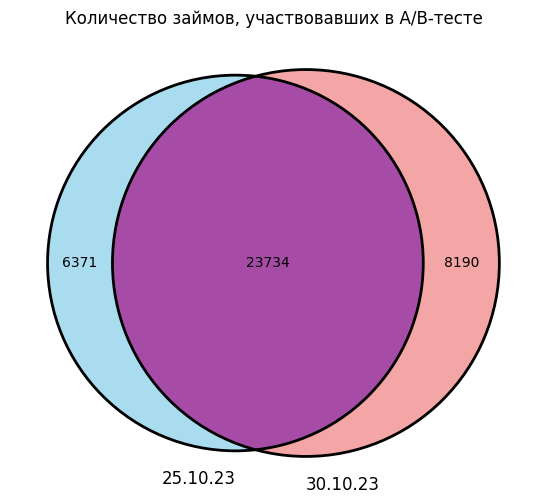

In [5]:
set25 = set(df[df['treat_date'] == '2023-10-25'].demand)
set30 = set(df[df['treat_date'] == '2023-10-30'].demand)

plt.figure(figsize=(8, 6))

venn = venn2(
    [set25, set30], 
    set_labels=('25.10.23', '30.10.23'),
    set_colors=('skyblue', 'lightcoral'),
    alpha=0.7
)

venn.get_patch_by_id('11').set_color('purple')
venn.get_patch_by_id('11').set_alpha(0.7)

venn2_circles(
    [set25, set30], 
    linestyle='-', 
    linewidth=2, 
    color='black'
)

plt.title("Количество займов, участвовавших в A/B-тесте")
plt.grid(False)
plt.show()

#### Как видно из диаграммы выше, бОльшая часть займов участвовала в A/B-тесте в оба дня. Займы, которые участвовали только в одном тесте, составляют 21% и 26% от объема выборок для 25.10 и 30.10 соответственно.   
#### _Определим имеющиеся комбинации флагов взаимодействия 25.10 и 30.10 в структуре займов, участвовавших в тесте два раза. Для этого построим матрицу сопряженности._

In [6]:
df25 = df[df['treat_date'] == pd.to_datetime('2023-10-25')]
df30 = df[df['treat_date'] == pd.to_datetime('2023-10-30')]

df_intersect = df25.merge(df30, on='demand', how='inner', suffixes=('_2510', '_3010'))
df_conti = df_intersect[['demand', 'treatment_flag_2510', 'treatment_flag_3010']]

contingency_table = pd.crosstab(
    df_conti['treatment_flag_2510'], 
    df_conti['treatment_flag_3010']
)

contingency_table.index = ['25.10 flag=0', '25.10 flag=1']
contingency_table.columns = ['30.10 flag=0', '30.10 flag=1']

fig = go.Figure(data=go.Heatmap(
    z=contingency_table.values,
    x=contingency_table.columns.tolist(),
    y=contingency_table.index.tolist(),
    text=contingency_table.values,
    texttemplate='%{text}',
    textfont={"size": 14},
    colorscale='Blues',
    hovertemplate='<b>%{y}</b><br>' +
                  '<b>%{x}</b><br>' +
                  'Количество: %{z}<br>' +
                  '<extra></extra>',
    showscale=True,
    colorbar={
        'title': {
            'text': 'Количество займов',
            'side': 'right',
            'font': {'size': 14}
        },
        'tickfont': {'size': 12},
        'thickness': 15,
        'len': 0.5
    },
    xgap=2,
    ygap=2
))

fig.update_layout(
    plot_bgcolor='gray',
    title={
        'text': 'Флаги взаимодействия займов в A/B тестах',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 14}
    },
    width=600,
    height=500,
    margin={'l':50, 'r': 50, 't': 50, 'b': 50},
    xaxis={
        'title': '30 октября',
        'tickfont': {'size': 14},
        'side': 'bottom'
    },
    yaxis={
        'title': '25 октября',
        'tickfont': {'size': 14},
        'autorange': 'reversed'
    }
)

fig.show()

#### Как видно из матрицы сопряженности, среди рассматриваемых займов имеются все возможные комбинации. Наиболее многочисленна категория займов, по которым отсутствовало целевое взаимодействие как во время первого дня (25.10), так и во время второго (30.10). Вторая по размеру категория описывает ситуацию, когда взаимодействие по займу не произошло в первом дне, но произошло во втором.  
  
#### <span style="color:rgb(100, 24, 63);">Наибольший интерес для дальнейшего анализа представляют две остальные __категории__:</span>   
#### <span style="color:rgb(100, 24, 63);">1. Целевое взаимодействие было в _первом_ дне теста, но отсутствовало во втором (4337 наблюдений);
#### <span style="color:rgb(100, 24, 63);">2. Целевое взаимодействие было и в _первом_ дне теста, и во _втором_ (4085 наблюдений).</span>   

#### <span style="color:rgb(100, 24, 63);">Несмотря на то, что по условию бизнес-логики платежи учитываются в течение 3 дней после взаимодействия, а между первым и вторым днем теста разница 5 дней, включение данных категорий в оценку результата A/B-теста может __исказить__ ее результат, так как факт свершившегося целевого взаимодействия 25 откября мог __оказать влияние__ на поведение заемщика 30 октября. Поэтому из выборки займов от 30 октября целесообразно __исключить__ займы, относящиеся к данным группам для получения более точных выводов.</span>


In [7]:
# Исключаем две категории займов из перечня займов, участвовавших во втором тесте

exclude1_0 = df_intersect[
    (df_intersect['treatment_flag_2510'] == 1) &
    (df_intersect['treatment_flag_3010'] == 0)
    ]['demand'].to_list()

exclude1_1 = df_intersect[
    (df_intersect['treatment_flag_2510'] == 1) &
    (df_intersect['treatment_flag_3010'] == 1)
    ]['demand'].to_list()


df30 = df30[(~df30['demand'].isin(exclude1_0)) & (~df30['demand'].isin(exclude1_1))]

# Промежуточный датафрейм со всеми займами
df = pd.concat([df25, df30], axis=0, ignore_index=True)

In [8]:
# Чтение файла со сведениями о платежах в датафрейм
df2 = pd.read_csv('../data/payments.csv', sep=';')
df2.columns = list(map(str.lower, df2.columns.values))

# Изменение типа данных столбца PAY_STAMP с object на datetime
df2['pay_stamp'] = pd.to_datetime(df2['pay_stamp'], dayfirst=True)
df2.head()

,payment_id,pay_stamp,demand
0,13987558,2023-10-18 17:12:00,35072400
1,14017760,2023-10-20 09:02:00,36764746
2,14025848,2023-10-20 19:07:00,37389598
3,14034783,2023-10-21 19:03:00,37712341
4,14086482,2023-10-25 07:03:00,37549942


In [9]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю payment_id:',\
      len(df2[df2.duplicated(['payment_id'])]), '- id платежей уникальны.')

print('Кол-во дубликатов по полю demand:',\
      len(df2[df2.duplicated(['demand'])]), '- по одному займу может быть несколько разных платежей.')

Кол-во дубликатов по полю payment_id: 0 - id платежей уникальны.
Кол-во дубликатов по полю demand: 1287 - по одному займу может быть несколько разных платежей.


In [10]:
# JOIN-им платежи к данным о займах:

total_df = df.merge(df2, on='demand', how='left')
total_df['payment_id'] = total_df['payment_id'].astype('Int64')
total_df.sample(15)

,demand,treat_date,treatment_flag,payment_id,pay_stamp
21025,37531270,2023-10-25,1,<NA>,NaT
23143,36383508,2023-10-25,1,<NA>,NaT
26100,37379973,2023-10-25,0,14099221,2023-10-25 15:19:00
3622,35217338,2023-10-25,0,<NA>,NaT
17262,35511394,2023-10-25,0,<NA>,NaT
23102,36249641,2023-10-25,0,<NA>,NaT
5778,38075483,2023-10-25,0,14025916,2023-10-20 19:12:00
47241,37562410,2023-10-30,1,<NA>,NaT
17011,37603801,2023-10-25,0,14103945,2023-10-25 20:22:00
46502,36339995,2023-10-30,0,<NA>,NaT


In [11]:
# Разделение датафрейма на 2 для дальнейшей обработки:

df_nan = total_df[total_df['payment_id'].isna()].copy() # датафрейм с займами, по которым платежи не поступали
df_pay = total_df[~total_df['payment_id'].isna()].copy() # датафрейм с займами, по которым платежи поступали

In [12]:
# # Нахождение разности дней между датой платежа и датой взаимодействия:

df_pay['delta_days'] = (df_pay['pay_stamp'] - df_pay['treat_date']).dt.days
df_pay.sample(10)

,demand,treat_date,treatment_flag,payment_id,pay_stamp,delta_days
5741,37796800,2023-10-25,0,14066355,2023-10-23 17:09:00,-2
45080,37459341,2023-10-30,1,13973756,2023-10-17 21:21:00,-13
972,36756873,2023-10-25,0,13968271,2023-10-17 12:43:00,-8
51715,37788874,2023-10-30,1,14248239,2023-11-03 10:01:00,4
30767,37915892,2023-10-25,0,14199296,2023-10-31 21:23:00,6
46641,37109884,2023-10-30,0,14253865,2023-11-03 14:19:00,4
1641,36771400,2023-10-25,0,14105328,2023-10-25 21:48:00,0
11780,36586480,2023-10-25,0,14261299,2023-11-03 21:57:00,9
15416,35203175,2023-10-25,0,14214359,2023-11-01 16:08:00,7
48826,36580975,2023-10-30,0,14219391,2023-11-02 05:57:00,3


In [13]:
# Фильтрация датафрейма согласно условию, что платежи учитываются в течение 3 дней после взаимодействия:

pd.DataFrame(df_pay[df_pay['delta_days'].isin(range(4))].delta_days.value_counts())

,count
delta_days,
0,1199
1,905
2,689
3,489


#### Таким образом, по займам, по которым поступал хотя бы один платёж, больше всего платежей поступало в день взаимодействия

#### _Разобьем займы с оплатами на две группы:_  
#### 1. _Те, для которых выполняется условие 3-дневного закрепления;_
#### 2. _Те, для которых оно нарушается (платеж поступил до взаимодействия или позднее, чем через 3 дня после взаимодействия)._  
#### _Вторую категорию отнесем к займам без оплаты_

In [14]:
# Среди займов с оплатами выделим те, для которых выполняется и нарушается условие 3-дневного закрепления
paid_3_days = df_pay[(df_pay['delta_days'] >= 0) & (df_pay['delta_days'] <= 3)].copy()

not_paid_3_days = df_pay[(df_pay['delta_days'] < 0) | (df_pay['delta_days'] > 3)].copy()
not_paid_3_days.drop(columns='delta_days', inplace=True)

In [15]:
# Агрегация датафрейма not_paid_3_days по количеству платежей для каждого займа:

not_paid_3_days_agg = not_paid_3_days.pivot_table(index=['demand', 'treat_date'], values='treatment_flag')
not_paid_3_days_agg.reset_index(drop=False , inplace=True)

df_nan = pd.concat([df_nan, not_paid_3_days_agg], axis=0, ignore_index=True)

# Создание столбца с количеством поступивших платежей:
df_nan['payments_amount'] = 0
df_nan.drop(columns=['payment_id', 'pay_stamp'], inplace=True)
df_nan

,demand,treat_date,treatment_flag,payments_amount
0,36026098,2023-10-25,1.0,0
1,36073351,2023-10-25,1.0,0
2,37540360,2023-10-25,1.0,0
3,37540643,2023-10-25,0.0,0
4,37621229,2023-10-25,0.0,0
...,...,...,...,...
50965,38287369,2023-10-30,1.0,0
50966,38302835,2023-10-30,1.0,0
50967,38313120,2023-10-30,0.0,0
50968,38314234,2023-10-30,0.0,0


In [16]:
# Агрегация датафрейма df_pay по количеству платежей для каждого займа:

df_pay_agg = paid_3_days.pivot_table(index=['demand', 'treat_date'],
                                values=['treatment_flag', 'delta_days'],
                                aggfunc={'treatment_flag': 'mean', 'delta_days': len})

df_pay_agg.reset_index(drop=False , inplace=True)
df_pay_agg.rename(columns={'delta_days': 'payments_amount'}, inplace=True)
df_pay_agg

,demand,treat_date,payments_amount,treatment_flag
0,33875999,2023-10-25,1,1.0
1,33986987,2023-10-25,3,0.0
2,34256627,2023-10-25,1,1.0
3,34261435,2023-10-25,1,1.0
4,34294035,2023-10-30,1,1.0
...,...,...,...,...
2998,38297752,2023-10-30,2,1.0
2999,38303354,2023-10-30,2,1.0
3000,38305513,2023-10-30,1,1.0
3001,38314493,2023-10-30,1,1.0


In [17]:
# Объединение обработанных датафреймов в единый итоговый датафрейм:

df_itog = pd.concat([df_pay_agg, df_nan], axis=0, ignore_index=True)
df_itog['payment_flag'] = (df_itog['payments_amount'] > 0).astype('int')
df_itog.head()

,demand,treat_date,payments_amount,treatment_flag,payment_flag
0,33875999,2023-10-25,1,1.0,1
1,33986987,2023-10-25,3,0.0,1
2,34256627,2023-10-25,1,1.0,1
3,34261435,2023-10-25,1,1.0,1
4,34294035,2023-10-30,1,1.0,1


## 2. Расчет описательных статистик и проведение статистических тестов

#### _Определим количество наблюдений (займов), среднее количество платежей на займ и долю займов с оплатой в разбивке по группам и датам:_

In [18]:
df_itog.groupby(['treatment_flag']).agg(
    n_obs = ('payments_amount', 'count'),
    avg_pays_count = ('payments_amount', 'mean'),
    pays_share = ('payment_flag', 'mean'))

,n_obs,avg_pays_count,pays_share
treatment_flag,,,
0.0,31723,0.058191,0.053557
1.0,22250,0.064539,0.058607


In [19]:
df_itog.groupby(['treatment_flag', 'treat_date']).agg(
    n_obs = ('payments_amount', 'count'),
    avg_pays_count = ('payments_amount', 'mean'),
    pays_share = ('payment_flag', 'mean'))

n_obs  avg_pays_count  pays_share
treatment_flag treat_date                                   
0.0            2023-10-25  19424        0.063118    0.057764
               2023-10-30  12299        0.050411    0.046914
1.0            2023-10-25  10926        0.070474    0.063884
               2023-10-30  11324        0.058813    0.053515

#### _Рассмотрим распределения количества платежей:_

In [20]:
pays_amount = df_itog.pivot_table(
    index=['payments_amount'],
    columns=['treat_date', 'treatment_flag'],
    values=['demand'],
    aggfunc=len
)

pays_amount = pays_amount.rename(columns={'demand': 'Кол-во займов'}, level=0)
pays_amount = pays_amount.astype('Int64')
pays_amount

Кол-во займов                         
treat_date         2023-10-25        2023-10-30       
treatment_flag            0.0    1.0        0.0    1.0
payments_amount                                       
0                       18302  10228      11722  10718
1                        1049    641        546    562
2                          52     48         24     33
3                          12      3          2      6
4                           8      6          5      5
5                           1   <NA>       <NA>   <NA>

#### Таким образом, в контрольной группе имеется 31,7 тыс. наблюдений, а в тестовой - 22,2 тыс. наблюдений.    
#### Среднее количество платежей и в контрольной, и в тестовой группе оказалось близко к нулю. Это говорит о том, что во всех группах по большинству займов в течение 3-х дней платежей не поступало.

#### _Рассмотрим доли оплаченных и неоплаченных займов по группам:_

In [21]:
control_data = df_itog[df_itog['treatment_flag'] == 0].payment_flag
test_data = df_itog[df_itog['treatment_flag'] == 1].payment_flag

data_to_plot = pd.DataFrame({
    'Контрольная': [1 - control_data.mean(), control_data.mean()],
    'Тестовая': [1 - test_data.mean(), test_data.mean()]
}, index=['Без оплаты', 'С оплатой'])

fig = go.Figure()

colors = px.colors.qualitative.Set1
for i, column in enumerate(data_to_plot.columns):
    fig.add_trace(go.Bar(
        name=column,
        x=data_to_plot.index,
        y=data_to_plot[column],
        text=[f'{val:.2%}' for val in data_to_plot[column]],
        textposition='outside',
        textfont=dict(size=12),
        marker_color=colors[i],
        hovertemplate=(
            '<b>Категория:</b> %{x}<br>' +
            '<b>Группа:</b> ' + column + '<br>' +
            '<b>Доля:</b> %{y:.2%}<br>' +
            '<extra></extra>'
        )
    ))

fig.update_layout(
    title=dict(
        text='Доли займов по группам',
        font=dict(size=14),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Категории',
        tickfont=dict(size=12),
        title_font=dict(size=14)
    ),
    yaxis=dict(
        title='Доли',
        tickformat='.0%',
        title_font=dict(size=14),
        tickfont=dict(size=12),
        range=[0, 1.1]
    ),
    barmode='group',
    legend=dict(
        title='Группы',
        title_font=dict(size=14),
        font=dict(size=12)
    ),
    width=700,
    height=500,
    margin=dict(l=50, r=50, t=50, b=50),
    plot_bgcolor='white'
)

fig.update_yaxes(showgrid=True, gridcolor='lightgray')

fig.show()

#### _Рассмотрим долю займов с оплатой в разбивке по датам взаимодействия:_

In [22]:
grouped_df = df_itog.groupby(['treatment_flag', 'treat_date'])['payment_flag'].mean().unstack()
grouped_df.columns = [col.strftime('%Y-%m-%d') for col in grouped_df.columns]

fig = go.Figure()

colors = px.colors.qualitative.Set1
for i, column in enumerate(grouped_df.columns):
    fig.add_trace(go.Bar(
        name=column,
        x=grouped_df.index,
        y=grouped_df[column],
        text=[f'{val:.2%}' for val in grouped_df[column]],
        textposition='outside',
        textfont=dict(size=12),
        marker_color=colors[i],
        hovertemplate=(
            '<b>Флаг взаимодействия:</b> %{x}<br>' +
            '<b>Дата:</b> ' + column + '<br>' +
            '<b>Доля:</b> %{y:.2%}<br>' +
            '<extra></extra>'
        )
    ))

fig.update_layout(
    title=dict(
        text='Доли займов с оплатой по группам и дате',
        font=dict(size=14),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Флаг взаимодействия',
        tickfont=dict(size=12),
        title_font=dict(size=14)
    ),
    yaxis=dict(
        tickformat='.0%',
        tickfont=dict(size=12),
        range=[0, grouped_df.values.max() * 1.1]
    ),
    barmode='group',
    legend=dict(
        title='Дата взаимодействия',
        title_font=dict(size=12),
        font=dict(size=11)
    ),
    width=700,
    height=500,
    margin=dict(l=50, r=50, t=50, b=50),
    plot_bgcolor='white'
)

fig.update_yaxes(showgrid=True, gridcolor='lightgray')

fig.show()

#### Таким образом, показатель доли займов с оплатой выше в тестовой группе - 5.9% против 5.4% в контрольной группе.

#### <span style="color:rgb(100, 24, 63);">Как видно из расчета среднего количества платежей, данная метрика не является информативной, так по абсолютному большинству займов как в контрольной, так и в тестовой группе, платежей после взаимодействия не поступало. Поэтому выборки для анализа сформируем из категориального __бинарного__ признака - __флага платежа__, а в качестве ключевых метрик возьмем __выборочные доли "успехов"__ (займов, по которым поступил платеж) для контрольной и тестовой группы соответственно.</span> 
 
#### <span style="color:rgb(100, 24, 63);">Основным методом анализа в такой ситуации (большой объем выборки, когда биномиальное распределение приближается к нормальному) является __Z-test для двух пропорций__, проверяющий гипотезу о том, является ли статистически значимым различие в двух долях. Так как доля займов с платежом в тестовой группе оказалась несколько больше, чем в контрольной, есть основание предполагать, что запущенная в A/B-тесте фича привнесла __положительный__ эффект, поэтому проведем Z-тест с правосторонней альтернативой.</span>

#### _1. Вычислим выборочные доли как точечные несмещенные оценки "успеха" в биномиальном распределении, а также определим для них 95%-е доверительные интервалы_

In [23]:
data = [
    {'count': control_data.sum(), 'nobs': control_data.count(), 'p_hat': control_data.mean(), 'name': 'Контрольная группа'},
    {'count': test_data.sum(), 'nobs': test_data.count(), 'p_hat': test_data.mean(), 'name': 'Тестовая группа'}
]

for dat in data:
    lower, upper = proportion_confint(count=dat['count'], nobs=dat['nobs'], alpha=0.05, method='normal')
    print(f'{dat['name']}: точечная оценка: {dat['p_hat']:.5f}, 95%-й доверительный интервал: [{lower:.5f}; {upper:.5f}].')

Контрольная группа: точечная оценка: 0.05356, 95%-й доверительный интервал: [0.05108; 0.05603].
Тестовая группа: точечная оценка: 0.05861, 95%-й доверительный интервал: [0.05552; 0.06169].


#### Из полученных расчетов видно, что доверительный интервал для выборочной доли из тестовой группы имеет совсем небольшое пересечение слева с интервалом для выборочной доли из контрольной группы.

#### _2. Проверим гипотезу о равенстве пропорций. Альтернативная гипотеза будет заключаться в том, что значение выборочной доли для тестовой группы будет статистически значимо превышать значение доли для контрольной группы. Таким образом, проведем Z-test с правосторонней альтернативой._

In [24]:
z_stat, p_value = proportions_ztest(
    count=[test_data.sum(), control_data.sum()],
    nobs=[test_data.count(), control_data.count()],
    alternative='larger'
)

z_stat, p_value

(np.float64(2.519091695853578), np.float64(0.00588290057710272))

#### <span style="color:rgb(100, 24, 63);">Таким образом, наблюдаемое значение статистики оказалось больше критического (p-value = 0.006 < 0.05), следовательно, нулевая __гипотеза о равенстве долей отклоняется__ на 5%-м уровне значимости. __Различие__ в долях оплаченных займов в контрольной и тестовой группе является __статистически значимым__.</span>   
#### <span style="color:rgb(100, 24, 63);">Итак, результаты A/B-теста говорят нам о том, что есть доказательство __превышения доли оплаченных займов__ в группе с внедренной фичей над контрольной группой. Относительный прирост конверсии в оплату в тестовой группе составил 9.3%. Значит, если мы хотим поддерживать качество сборов на высоком уровне, нам следует выводить данную фичу в продакшен.</span>